In [50]:
import numpy as np
from collections import defaultdict
import time
import datetime
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import glob
import os

In [51]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [52]:
#load pretrained model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = torch.nn.Linear(num_ftrs, 2)

/home/nbuser/anaconda3/envs/mypy3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nbuser/anaconda3/envs/mypy3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [54]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.ImageFolder(root="poison/notebooks/data/noisy_vs_clean/train",transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(root="poison/notebooks/data/noisy_vs_clean/test",transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

EPOCHS=10
BATCH_SIZE = 32
TOTAL_SIZE = 9800
STEPS_PER_EPOCH = TOTAL_SIZE // BATCH_SIZE
TOTAL_TEST_SIZE = 200 
STEPS_PER_TEST_EPOCH = TOTAL_TEST_SIZE // BATCH_SIZE

In [55]:
trainset

Dataset ImageFolder
    Number of datapoints: 9800
    Root location: poison/notebooks/data/noisy_vs_clean/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [56]:
trainset.classes

['cleanfrog', 'realNoisyFrogs']

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Sending model to device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.fc.parameters(), lr=0.0007
)  # lr should be kept low so that the pre-trained weights don't change easily

In [58]:
def get_test():
    test_loss = []
    correct = 0
    incorrect = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for batch_idx, (data, target) in enumerate(testloader):
        if batch_idx == STEPS_PER_TEST_EPOCH:
            break

        # Model is used to predict the test data so we are switching off the gradient

        with torch.no_grad():

            data = data.to(device)
            target = target.long().to(device)
            output = model(data)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, target)

            # Note that optimizer is not used because the model shouldn't learn the test dataset

            for i in range(BATCH_SIZE):
                a = []
                for j in output[i]:
                    a.append(float(j.detach()))

                pred = a.index(max(a))

                if pred == int(target[i]):
                    correct = correct + 1

                else:
                    incorrect = incorrect + 1

        test_loss.append(float(loss.detach()))
    print("CORRECT: " + str(correct), "INCORRECT: " + str(incorrect),"TEST ACCURACY: "+str(correct/(correct+incorrect)))
    return (
            correct/(incorrect+correct),
            sum(test_loss)/len(test_loss),
    )

In [59]:
acc_ , loss_ = get_test()
print("ACCURACY AND LOSS BEFORE TUNING")
print("ACCURACY : "+str(acc_),"LOSS : "+str(loss_))

CORRECT: 92 INCORRECT: 100 TEST ACCURACY: 0.4791666666666667
ACCURACY AND LOSS BEFORE TUNING
ACCURACY : 0.4791666666666667 LOSS : 0.9657054990530014


In [60]:
avg_train_accuracy_history = []
avg_test_accuracy_history = []

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # set model to training mode
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        preds = torch.argmax(output, dim=1)
        correct = (preds == target).sum().item()
        
        running_loss += loss.item() * data.size(0)
        running_correct += correct
        total_samples += data.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_correct / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()  # set model to eval mode
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            preds = torch.argmax(output, dim=1)
            correct = (preds == target).sum().item()
            
            running_loss += loss.item() * data.size(0)
            running_correct += correct
            total_samples += data.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_correct / total_samples
    return epoch_loss, epoch_acc

best_acc = 0.0
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, testloader, criterion, device)
    end_time = time.time()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Time: {end_time - start_time:.2f}s")
    
    avg_train_accuracy_history.append(train_acc)
    avg_test_accuracy_history.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "poison/notebooks/model_save/model.pth")


Epoch 1/10, Train Loss: 0.3471, Train Acc: 0.8672, Test Loss: 0.2065, Test Acc: 0.9300, Time: 51.88s
Epoch 2/10, Train Loss: 0.1968, Train Acc: 0.9330, Test Loss: 0.1535, Test Acc: 0.9500, Time: 52.57s
Epoch 3/10, Train Loss: 0.1564, Train Acc: 0.9471, Test Loss: 0.1458, Test Acc: 0.9500, Time: 53.03s
Epoch 4/10, Train Loss: 0.1444, Train Acc: 0.9483, Test Loss: 0.1343, Test Acc: 0.9650, Time: 50.76s
Epoch 5/10, Train Loss: 0.1353, Train Acc: 0.9516, Test Loss: 0.1267, Test Acc: 0.9550, Time: 41.76s
Epoch 6/10, Train Loss: 0.1367, Train Acc: 0.9495, Test Loss: 0.1224, Test Acc: 0.9600, Time: 42.27s
Epoch 7/10, Train Loss: 0.1322, Train Acc: 0.9514, Test Loss: 0.1298, Test Acc: 0.9600, Time: 43.90s
Epoch 8/10, Train Loss: 0.1305, Train Acc: 0.9503, Test Loss: 0.1199, Test Acc: 0.9650, Time: 50.37s
Epoch 9/10, Train Loss: 0.1251, Train Acc: 0.9533, Test Loss: 0.1353, Test Acc: 0.9650, Time: 37.74s
Epoch 10/10, Train Loss: 0.1231, Train Acc: 0.9526, Test Loss: 0.1153, Test Acc: 0.9650, Ti

In [64]:
image_paths = sorted(glob.glob(os.path.join("poison/notebooks/data/noisy_vs_clean/test", "*.*")))

with open("labels.txt", "w") as f:
    with torch.no_grad():
        for img_path in image_paths:
            img = Image.open(img_path).convert("RGB")
            input_tensor = transform(img).unsqueeze(0).to(device)
            
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()
            
            label = "bad" if pred == 1 else "good"
            f.write(label + "\n")

In [62]:
print("ACCURACY : ", best_acc)

ACCURACY :  0.965


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

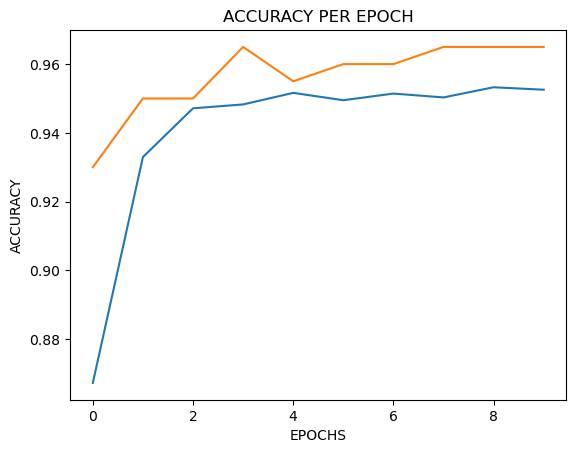

In [63]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend